In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import grad
from torch.autograd.functional import hessian
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
from tqdm import tqdm
from torch.optim import Adam, SGD, LBFGS

In [3]:
def same_seed(seed):
    # set seeds
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

In [56]:
def search_loss_fn(z, f, type='A', coeff=0.1):
    def loss_A(x, e):
        w, h = x.size()
        f_X = f(x, e)
        f_Z = f(z, e)
        diff_loss = f_Z - f_X
        dist_loss = -torch.linalg.norm(x - z)
        first_order_loss = torch.linalg.norm(grad(f(x, e), x, create_graph=True)[0])
        second_order_loss = -torch.linalg.eigvalsh(hessian(f, (x, e), create_graph=True)[0][0].reshape(w,h,-1).reshape(w*h,-1))[0]
        return diff_loss + coeff * (first_order_loss + second_order_loss), diff_loss.item(), dist_loss.item(), first_order_loss.item(), second_order_loss.item()
    def loss_B(x, e):
        w, h = x.size()
        zeros = torch.zeros_like(e)
        f_X = f(x, zeros)
        f_Z = f(z, zeros)
        diff_loss = f_Z - f_X
        dist_loss = -torch.linalg.norm(x - z)
        first_order_loss = torch.linalg.norm(grad(f(x, zeros), x, create_graph=True)[0])
        second_order_loss = -torch.linalg.eigvalsh(hessian(f, (x, zeros), create_graph=True)[0][0].reshape(w,h,-1).reshape(w*h,-1))[0]
        return diff_loss + coeff * torch.max(first_order_loss, second_order_loss), diff_loss.item(), dist_loss.item(), first_order_loss.item(), second_order_loss.item()
    return loss_A if type == 'A' else loss_B

In [5]:
@torch.no_grad()
def project(x, e, max_norm):
    x[len(x) // 2] = 0
    norm_E = torch.linalg.norm(e, ord=2)
    if norm_E > max_norm:
        e = e / norm_E * max_norm

In [45]:
def gradient_descent(P: List[torch.Tensor], z: torch.Tensor, device, coeff=(1,4), loss_type='A', optim='SGD', iters=3000, lr=0.001, max_norm=1e-1):
    same_seed(0)
    # Compute the global optimal solution
    def f(x, e):
        r = torch.zeros_like(e)
        for i, p in enumerate(P):
            pred = x.T @ p @ x
            GT = z.T @ p @ z
            diff = (pred - GT).squeeze() - e[i]
            r[i] += diff
        return r.square().sum()
    
    x = torch.rand(z.size(), requires_grad=True).to(device)
    e = torch.zeros(len(P), requires_grad=True).to(device)
    project(x, e, max_norm)
    # vector_length = len(z) // 2
    # x[vector_length] = 0 # remove the redundancy of absolute phase
    # Initialize optimizers
    if optim == 'SGD':
        optimizer = SGD([x, e], lr=lr, momentum=0.9, weight_decay=1e-4)
    elif optim == 'Adam':
        optimizer = Adam([x, e], lr=lr, weight_decay=1e-4)
    else:
        raise NotImplementedError

    losses = []
    for i in range(iters):
        alpha = coeff[0] + i * (coeff[1] - coeff[0]) / iters
        criterion = search_loss_fn(z, f, loss_type, alpha)
        
        optimizer.zero_grad()    
        loss, diff, dist, grad, hess = criterion(x, e)
        loss.backward()
        torch.nn.utils.clip_grad_norm_([x, e], max_norm=1.0, norm_type=2)
        optimizer.step()
        # Adjust learning rate
        new_lr = 0.5 * (lr + 2e-4) + 0.5 * (lr - 2e-4) * np.cos(np.pi * i / iters)
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
        # project
        project(x, e, max_norm)
        # Record loss
        losses.append((loss.item(), diff, dist, grad, hess))
    return f, x, e, losses
    

In [35]:
def create_p(p_r, p_i, real=True):
    if real:
        return torch.cat([torch.cat([p_r, -p_i], dim=1), torch.cat([p_i, p_r], dim=1)], dim=0)
    else:
        return torch.cat([torch.cat([p_i, p_r], dim=1), torch.cat([-p_r, p_i], dim=1)], dim=0)

In [61]:
def plot_loss(losses):
    fig, ax = plt.subplots(3, 2, figsize=(20, 30), tight_layout=True)
    loss = [loss[0] for loss in losses]
    diff = [loss[1] for loss in losses]
    dist = [loss[2] for loss in losses]
    grad = [loss[3] for loss in losses]
    hess = [loss[4] for loss in losses]
    
    ax[0][0].plot(loss)
    ax[0][1].plot(diff)
    ax[1][0].plot(dist)
    ax[1][1].plot(grad)
    ax[2][0].plot(hess)

    ax[0][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][0].set_ylabel(r"$g(X,Z,E)$", fontsize=30)
    ax[0][0].set_title(f"Total Loss vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].grid()

    ax[0][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][1].set_ylabel(r"$f(Z)-f(X)$", fontsize=30)
    ax[0][1].set_title(r"$f(Z)-f(X)$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].grid()

    ax[1][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|X-Z\|_F$", fontsize=30)
    ax[1][0].set_title(r"$\|X-Z\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].grid()

    ax[1][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][1].set_ylabel(r"$\|\nabla_Xf(X)\|_F$", fontsize=30)
    ax[1][1].set_title(r"$\|\nabla_Xf(X)\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    ax[1][1].set_yscale('log')
    ax[1][1].grid()

    ax[2][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][0].set_ylabel(r"$-\lambda_{min}(\nabla^2_Xf(X))$", fontsize=30)
    ax[2][0].set_title(r"$-\lambda_{min}(\nabla^2_Xf(X))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][0].xaxis.set_tick_params(labelsize=20)
    ax[2][0].yaxis.set_tick_params(labelsize=20)
    ax[2][0].set_yscale('log')
    ax[2][0].grid()

    # ax[2][1].set_xlabel("# of GD Updates", fontsize=30), 
    # ax[2][1].set_ylabel(r"$-\lambda_{min}(\nabla^2_Zf(Z))$", fontsize=30)
    # ax[2][1].set_title(r"$-\lambda_{min}(\nabla^2_Zf(Z))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    # ax[2][1].xaxis.set_tick_params(labelsize=20)
    # ax[2][1].yaxis.set_tick_params(labelsize=20)
    # ax[2][1].grid()

In [62]:
p1_r = torch.tensor([
    [1.0, 0.0],
    [0.0, 0.0]
])
p1_i = torch.tensor([
    [0.0, 0.0],
    [0.0, 0.0]
])
p2_r = torch.tensor([
    [0, -50/101],
    [-50/101, 100/101]
])
p2_i = torch.tensor([
    [0, -500/101],
    [500/101, 0]
])
p3_r = torch.tensor([
    [0, -50/101],
    [50/101, 0]
])
p3_i = torch.tensor([
    [0, -500/101],
    [-500/101, 1000/101]
])
p4_r = torch.tensor([
    [100/101, -50/101],
    [-50/101, 0]
])
p4_i = torch.tensor([
    [0, 500/101],
    [-500/101, 0]
])
_P = [(p1_r, p1_i, True), (p2_r, p2_i, True), (p3_r, p3_i, False), (p4_r, p4_i, True)]

tensor(10.2355)
tensor([[ 0.8665],
        [ 0.2848],
        [ 0.0000],
        [-0.2018]])
tensor([0., 0., 0., 0.])


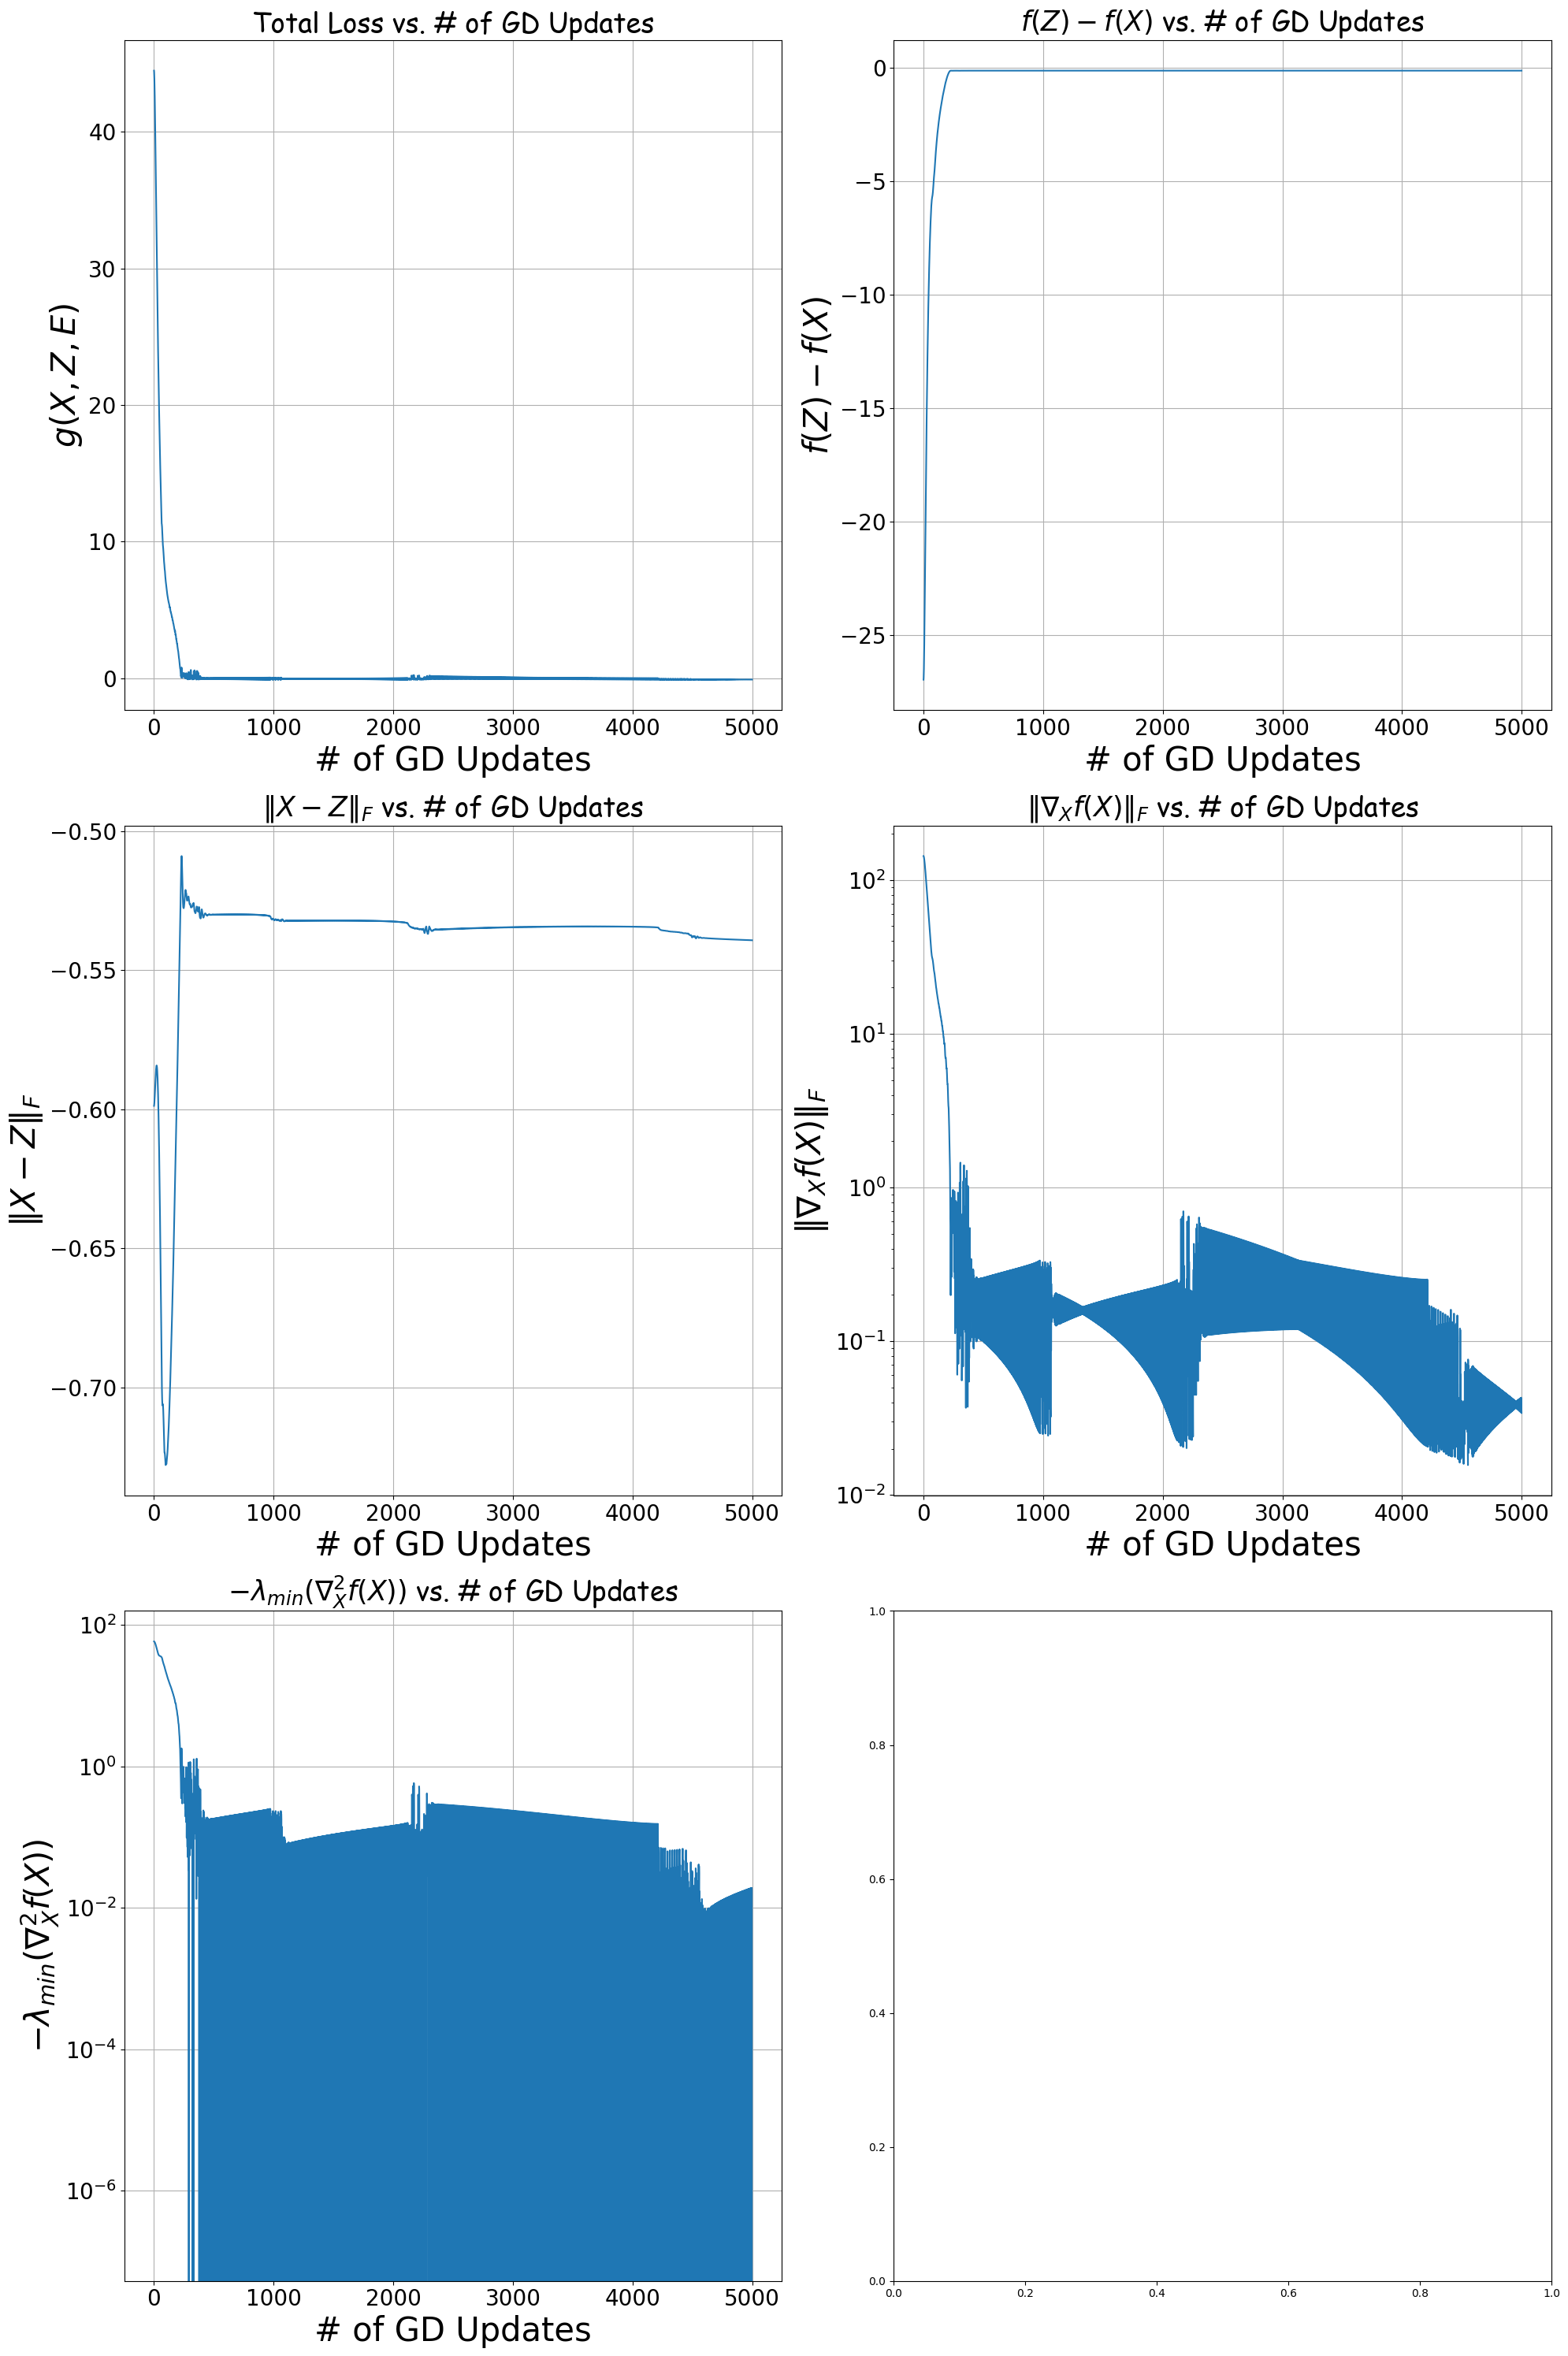

In [63]:
max_norm    = 0.1
iters       = 5000
lr          = 0.001
coeff       = (0.5,0.5)
loss_type   = 'B'
optim       = 'SGD'
device      = 'cuda:0' if torch.cuda.is_available() else 'cpu'

P = [create_p(*p) for p in _P]
z = torch.tensor([1, 0.8071, 0, -0.1893]).unsqueeze(-1)
f, x, e, losses = gradient_descent(P, z, device, coeff, loss_type, optim, iters, lr, max_norm)
local_min = torch.tensor([0.87, 0.28, 0, -0.2]).unsqueeze(-1)
saddle = torch.tensor([0.846, 0.34, 0, -0.2125]).unsqueeze(-1)
local_max = torch.tensor([0.0, 0.0, 0.0, 0.0]).unsqueeze(-1)
print(f(local_max, torch.zeros(len(P))))
print(x.data)
print(e.data)
plot_loss(losses)